# Below is the code implementation of increasing the accuracy of the research paper

We applied One hot encoding only as a preprocessing technique. Transfer Learning using EfficientNetB0 is applied to MRI brain images while adding GlobalaveragePool to get generalized ppooling value while reducing feature map size, Dropout to reduce overfitiing and Dense layer for classification. Saving the best model while monitoring validation accuracy during training; ReduceLROnPlateau callback is introduces to reduce the larning rate after a non improvement of patience 2, with minimum difference of 0.001 and whith factor of 0.3 and training for 12 epochs. Then analysing the results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings





In [2]:
for dirname, _, filenames in os.walk('Seminar'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

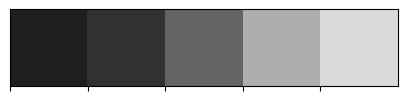

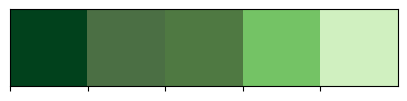

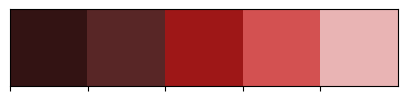

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 61.26it/s]


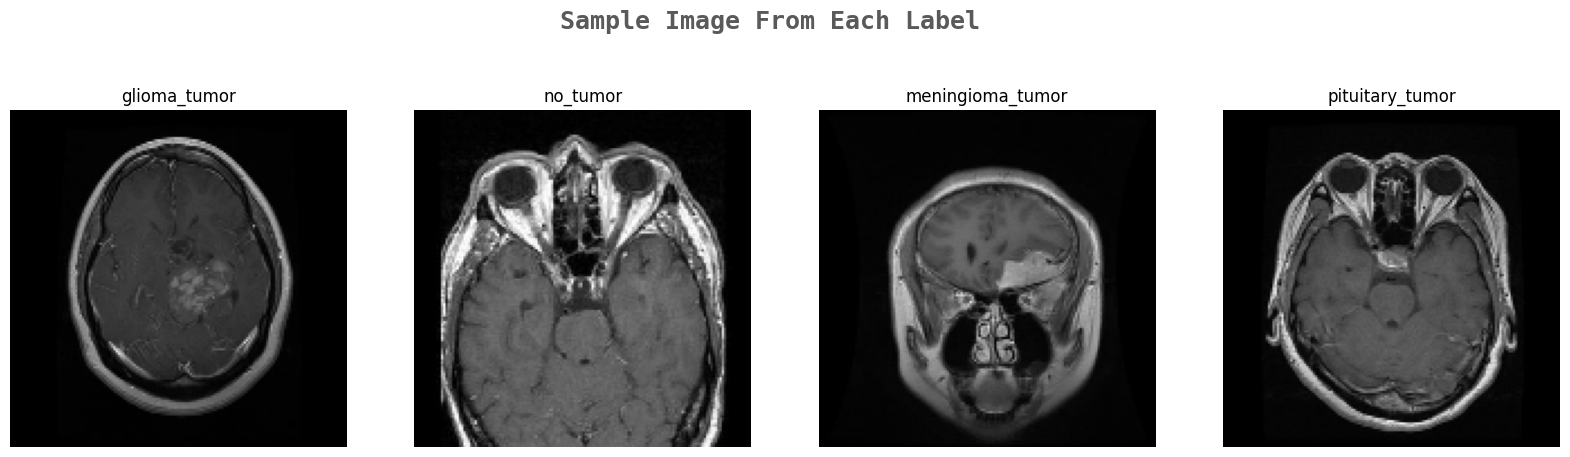

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

Divide datasets

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

one hot encoding

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Transfer Learning using EfficientNetB0.

EfficientNetB0 is a convolutional neural network (CNN) architecture that scales uniformly across depth, width, and resolution using a compound scaling method. It consists of 16 layers with a combination of mobile inverted bottleneck convolution (MBConv) blocks, skip connections, and squeeze-and-excitation layers, all optimized for both accuracy and computational efficiency

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

GlobalAveragePooling2D -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

Dropout -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

Dense -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Saving the best model while monitoring validation accuracy during training; ReduceLROnPlateau callback is introduces to reduce the larning rate after a non improvement of patience 2, with minimum difference of 0.001 and whith factor of 0.3

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

Training the model with 32 batch size for 12 epochs while monitoring the validation accuracy

In [15]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7362 - loss: 0.6767
Epoch 1: val_accuracy improved from -inf to 0.84014, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7373 - loss: 0.6742 - val_accuracy: 0.8401 - val_loss: 0.8424 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9362 - loss: 0.1834
Epoch 2: val_accuracy improved from 0.84014 to 0.88776, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9362 - loss: 0.1835 - val_accuracy: 0.8878 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9538 - loss: 0.1390
Epoch 3: val_accuracy did not improve from 0.88776
83/83 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9538 - loss: 0.1390 - val_accuracy: 0.8571 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9453 - loss: 0.1363
Epoch 4: val_accuracy improved

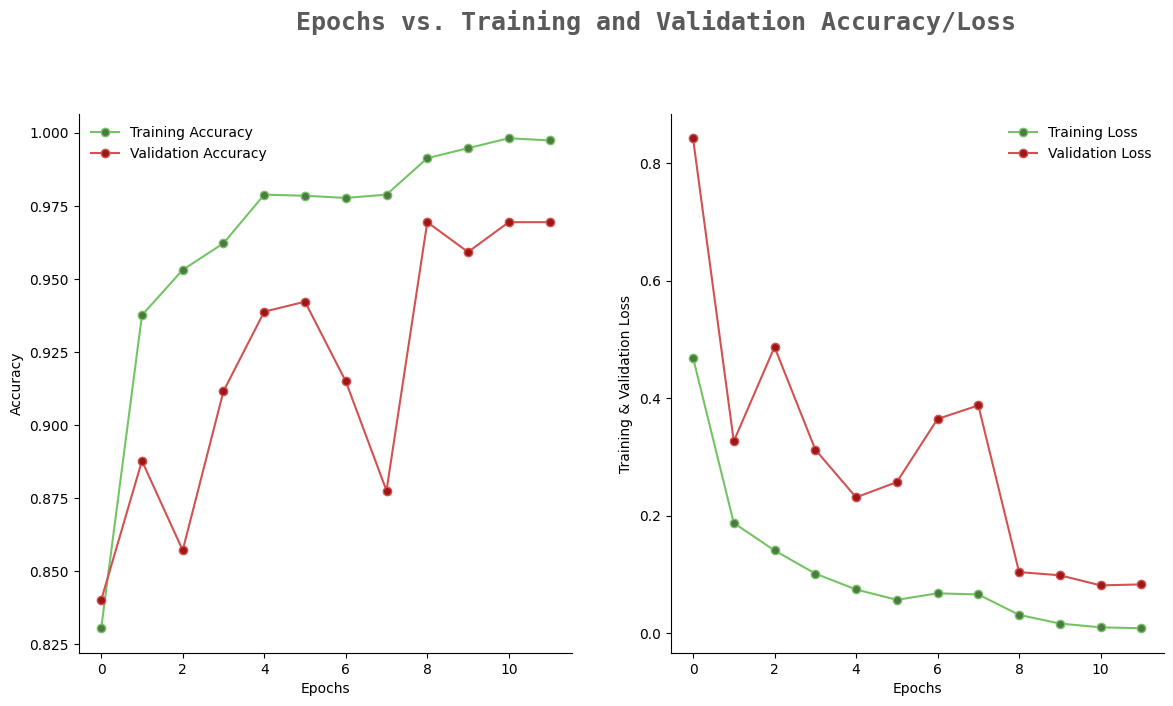

In [16]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

From the Graph we see that the model is trained well with consistent increasing and decreasing of training accuracy and loss respectively. However in Validation the model fluctuates a lot which can indicate some overfitting and therefore the results fluctuate with number of intervals.

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step


In [18]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        93
           1       0.96      1.00      0.98        51
           2       0.94      0.98      0.96        96
           3       0.99      1.00      0.99        87

    accuracy                           0.97       327
   macro avg       0.97      0.98      0.97       327
weighted avg       0.97      0.97      0.97       327



Report shows that the prediction for each class(0,1,2,3) is nearly accurate with the highest precision for class 0 which is 1.0 . 

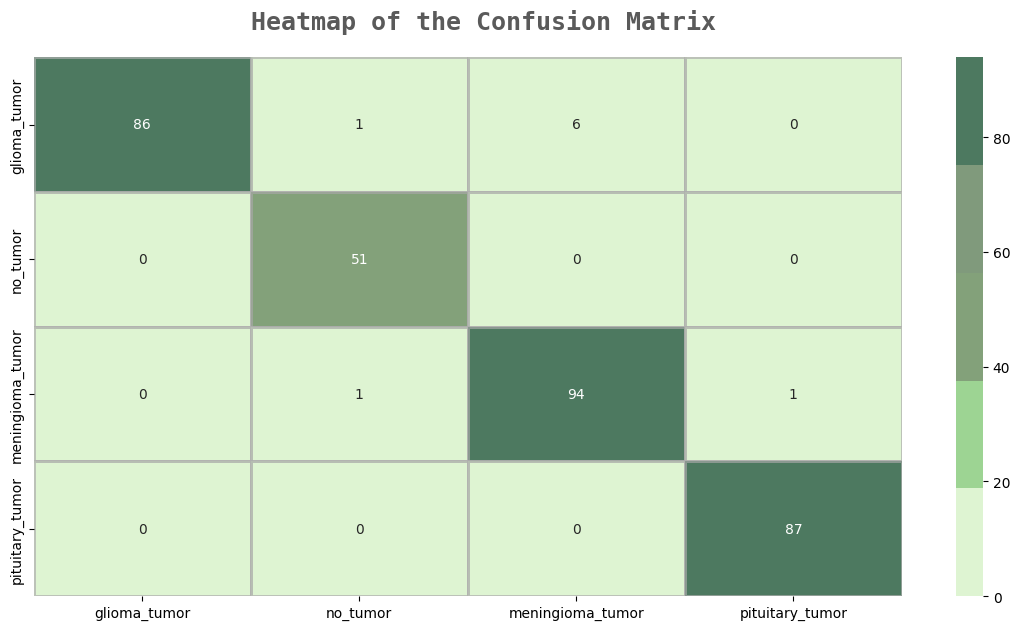

In [19]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_new, pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.25%


In [21]:
train_eval = model.evaluate(X_train, y_train)
print(f"Training Set Accuracy: {train_eval[1] * 100:.2f}%")


92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - accuracy: 0.9995 - loss: 0.0020
Training Set Accuracy: 99.63%


The research paper has the training accuracy of 96.47% and validation accuracy of 93.44% Our implementation has training accuracy of 99.63% and validation accuracy of 97.25% which meas that transfer learning indeed helped the model learn better and extract better features and train well also. Although our dataset was small but the images requires much feature attention therefore EfficientNetB0 with its complexity dis not impose overfitting but helped in learning the features.

# ❌❌❌❌❌❌❌❌ Ignore This Output ❌❌❌❌❌❌❌❌❌

In [7]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Paths to your dataset
train_dir = 'Training'
test_dir = 'Testing'

labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 80

# Load Data
def load_data(directory):
    X, y = [], []
    for label in labels:
        path = os.path.join(directory, label)
        for img_name in os.listdir(path):
            img = cv2.imread(os.path.join(path, img_name))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(labels.index(label))
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)


In [9]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=90, vertical_flip=True)

# Augment the training data and concatenate the original data with augmented data
X_train_augmented, y_train_augmented = [], []

for batch_X, batch_y in datagen.flow(X_train, y_train, batch_size=32, shuffle=False):
    X_train_augmented.append(batch_X)
    y_train_augmented.append(batch_y)
    if len(X_train_augmented) * 32 >= len(X_train):  # Stop after augmenting enough samples
        break

X_train_augmented = np.concatenate(X_train_augmented, axis=0)
y_train_augmented = np.concatenate(y_train_augmented, axis=0)

# Concatenate original and augmented data
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train_augmented), axis=0)

In [10]:
# Normalization and one-hot encoding
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

In [11]:
# Train-Test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# 2D CNN Model for Classification
def build_2d_cnn(input_shape, n_classes):
    input_img = Input(shape=input_shape)

    # 2D CNN Layers
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input_img, output)
    return model


In [12]:
cnn_model = build_2d_cnn((image_size, image_size, 3), len(labels))
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Callbacks
checkpoint_cnn = ModelCheckpoint('cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [20]:
# Train CNN
history_cnn = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, callbacks=[checkpoint_cnn, reduce_lr])

Epoch 1/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9995 - loss: 0.0075
Epoch 1: val_accuracy improved from 0.89199 to 0.89721, saving model to cnn_model.keras
323/323 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.9995 - loss: 0.0075 - val_accuracy: 0.8972 - val_loss: 0.4631 - learning_rate: 9.0000e-05
Epoch 2/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9986 - loss: 0.0084
Epoch 2: val_accuracy did not improve from 0.89721
323/323 ━━━━━━━━━━━━━━━━━━━━ 71s 219ms/step - accuracy: 0.9986 - loss: 0.0084 - val_accuracy: 0.8902 - val_loss: 0.4632 - learning_rate: 9.0000e-05
Epoch 3/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9987 - loss: 0.0073
Epoch 3: val_accuracy did not improve from 0.89721

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
323/323 ━━━━━━━━━━━━━━━━━━━━ 67s 207ms/step - accuracy: 0.9987 - loss: 0.0073 - val_accuracy: 0.8972 - val_loss: 0.4507 - learning_rate: 9.0000e-05
Epoch 4/20
323/323 ━━━━━━

In [19]:
# Print the final training accuracy with epoch 12
final_train_acc = history_cnn.history['accuracy'][-1]  # Get the last epoch's training accuracy
final_val_acc = history_cnn.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Training Accuracy: 99.77%
Final Validation Accuracy: 88.50%


In [22]:
# CNN Evaluation with 12 epochs
cnn_eval = cnn_model.evaluate(X_test, y_test)
print(f"2D CNN Model Accuracy: {cnn_eval[1] * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5298 - loss: 10.4815
2D CNN Model Accuracy: 72.59%


In [23]:
# Classification Report and Confusion Matrix for CNN with 12 epochs
pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


In [24]:
print("2D CNN Classification Report:")
print(classification_report(y_test_cnn, pred_cnn, target_names=labels))

2D CNN Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.20      0.33       100
        no_tumor       0.62      0.98      0.76       105
meningioma_tumor       0.73      0.95      0.83       115
 pituitary_tumor       0.92      0.73      0.81        74

        accuracy                           0.73       394
       macro avg       0.82      0.71      0.68       394
    weighted avg       0.80      0.73      0.68       394



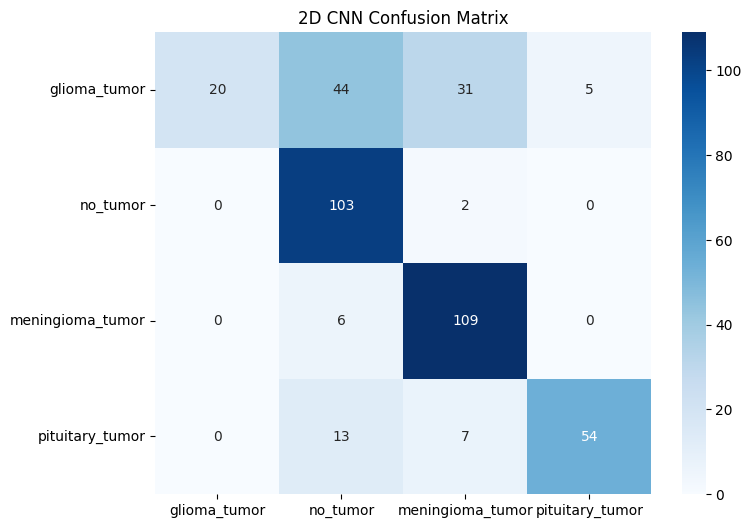

In [25]:
# Confusion Matrix with 12 epochs
conf_matrix_cnn = confusion_matrix(y_test_cnn, pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('2D CNN Confusion Matrix')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


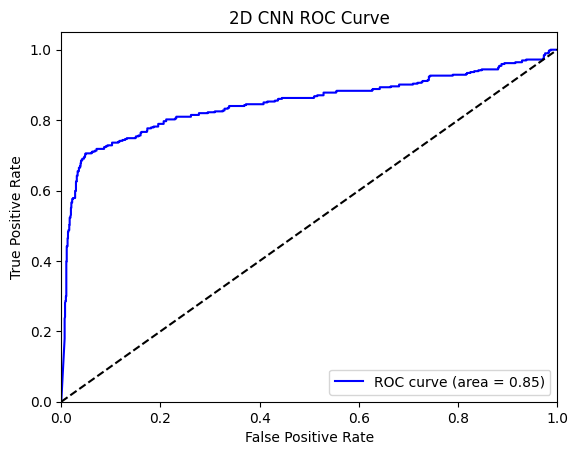

In [26]:
# ROC Curve for CNN wih 12 epochs
fpr, tpr, _ = roc_curve(y_test.ravel(), cnn_model.predict(X_test).ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('2D CNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


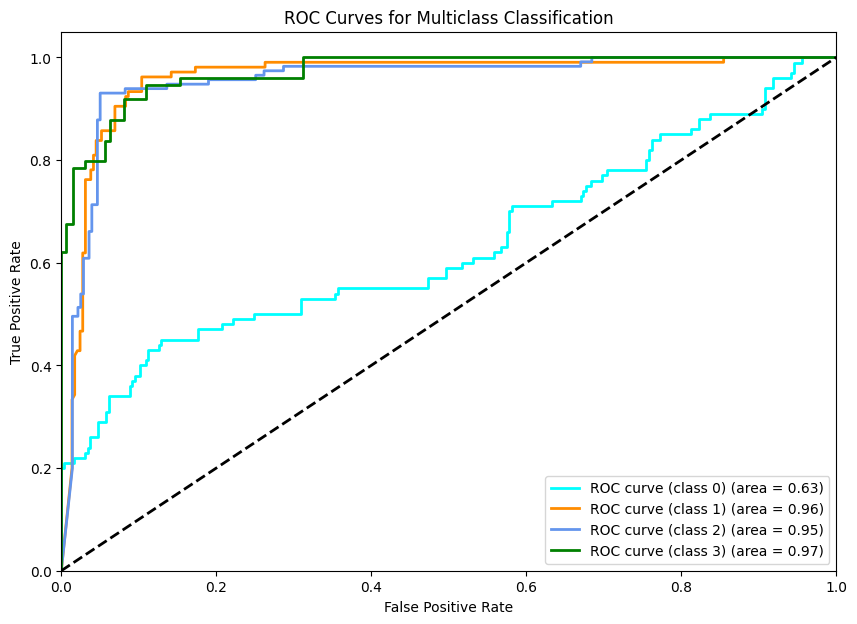

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle
# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # 4 classes: [0, 1, 2, 3]
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_pred_prob = cnn_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

# Plotting details
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()